In [1]:
%matplotlib inline
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import optim
from torch.nn import functional as F
import os, os.path  
import pickle
from glob import glob
import os

import torch.nn as nn
import seaborn as sns
from tqdm import trange
sns.set()

warnings.filterwarnings(action='ignore', message='Setting attributes')

C:\Users\sky\anaconda3\envs\cse\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

ROOT_PATH = 'C:\\Users\\sky\\DESKTOP\\argo2\\'

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    #f_in = ROOT_PATH + split + "/" + city + "_inputs"
    f_in = ROOT_PATH + split + "\\" + city + "_inputs"
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    outputs = None
    
    if split=="train":
        #f_out = ROOT_PATH + split + "/" + city + "_outputs"
        f_out = ROOT_PATH + split + "\\" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)

    return inputs, outputs


In [3]:
class MyRnn(nn.Module):
    def __init__(self, in_d=2, out_d=2, hidden_d=4, num_hidden=1):
        super(MyRnn, self).__init__()        
        self.encoder = nn.LSTM(input_size = in_d,hidden_size = hidden_d,num_layers = num_hidden,batch_first = True)
        self.mlp = nn.Sequential()
        self.mlp.add_module("layer0",nn.Linear(hidden_d,256))
        self.mlp.add_module("relu0",  nn.ReLU())
        self.mlp.add_module("layer1",nn.Linear(256,128))
        self.mlp.add_module("relu1",  nn.ReLU())
        self.mlp.add_module("layer2", nn.Linear(128,out_d))
    
    def forward(self,x):
        h = self.init_hidden_state(x.size()[0])
        output,h = self.encoder(x,h)
        output = output[:,-1]

        x = self.mlp(output).view(x.size()[0],int(out_d/in_d),in_d)       
        return x

    def init_hidden_state(self,batch_size):
        h_0 = torch.randn(num_hidden, 1, hidden_d, dtype=torch.float32).to(torch.device('cuda'))
        c_0 = torch.randn(num_hidden, 1, hidden_d, dtype=torch.float32).to(torch.device('cuda'))
        return (h_0,c_0)

In [4]:
split = 'train'
cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
#cities = ["palo-alto"] # testing only

total =[]
for city in cities:
    data = get_city_trajectories(city = city, split = split)
    total.extend(torch.cat((torch.tensor(data[0], dtype=torch.float32),torch.tensor(data[1], dtype=torch.float32)),dim=1))

offset = []
new_total = []
for each in total:
    #mean = each[:50].mean(dim=0)
    mean = each[0]
    offset.append(mean)
    new_total.append(((each-mean)/100).reshape(1,110,2).to(torch.device('cuda')))

In [27]:
in_d = 2
out_d = 2*60
hidden_d = 128
num_hidden = 3
n_epochs = 10

rnn = MyRnn(in_d, out_d, hidden_d, num_hidden).to(torch.device('cuda'))
loss = []
criterion = nn.MSELoss()
opt = torch.optim.Adam(params=rnn.parameters(), lr=0.00001)
for e in trange(n_epochs):
    track=0
    for s in new_total:
        pred = rnn(s[:,:50,:])
        err = criterion(pred, s[:,50:,:])
        opt.zero_grad()
        err.backward()
        opt.step()
        loss.append(err.item())
        track += 1
        if (track%10000==0):
            print(track/len(new_total)*100)
            plt.plot(loss)
            plt.ylabel('Loss')
            plt.xlabel('iteration')
            plt.yscale("log")
            plt.savefig('train_progress.png')
            plt.clf()

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.49063861522157237
0.9812772304431447
1.4719158456647172
1.9625544608862895
2.453193076107862
2.9438316913294345
3.4344703065510065
3.925108921772579
4.415747536994152
4.906386152215724
5.397024767437297
5.887663382658869
6.378301997880441
6.868940613102013
7.359579228323586
7.850217843545158
8.34085645876673
8.831495073988304
9.322133689209876
9.812772304431448
10.30341091965302
10.794049534874594
11.284688150096166
11.775326765317738
12.26596538053931
12.756603995760882
13.247242610982454
13.737881226204026
14.2285198414256
14.719158456647172
15.209797071868744
15.700435687090316
16.19107430231189
16.68171291753346
17.172351532755034
17.662990147976608
18.153628763198178
18.64426737841975
19.134905993641325
19.625544608862896
20.11618322408447
20.60682183930604
21.097460454527614
21.588099069749187
22.078737684970758
22.56937630019233
23.060014915413905
23.550653530635476
24.04129214585705
24.53193076107862
25.02256937630019
25.513207991521764
26.003846606743338
26.494485221964908
2

  1%|▊                                                                             | 1/100 [16:03<26:29:43, 963.47s/it]

0.49063861522157237
3.4344703065510065
3.925108921772579
4.415747536994152
4.906386152215724
5.397024767437297
5.887663382658869
6.378301997880441
6.868940613102013
7.359579228323586
7.850217843545158
8.34085645876673
8.831495073988304
9.322133689209876
9.812772304431448
10.30341091965302
10.794049534874594
11.284688150096166
11.775326765317738
12.26596538053931
12.756603995760882
13.247242610982454
13.737881226204026
14.2285198414256
14.719158456647172
15.209797071868744
15.700435687090316
16.19107430231189
16.68171291753346
17.172351532755034
17.662990147976608
18.153628763198178
18.64426737841975
19.134905993641325
19.625544608862896
20.11618322408447
20.60682183930604
21.097460454527614
21.588099069749187
22.078737684970758
22.56937630019233
23.060014915413905
23.550653530635476
24.04129214585705
24.53193076107862
25.02256937630019
25.513207991521764
26.003846606743338
26.494485221964908
26.98512383718648
27.475762452408052
27.966401067629626
28.4570396828512
28.94767829807277
29.4

  2%|█▌                                                                            | 2/100 [32:12<26:19:08, 966.82s/it]

0.49063861522157237
0.9812772304431447
1.4719158456647172
1.9625544608862895
2.453193076107862
2.9438316913294345
3.4344703065510065
3.925108921772579
4.415747536994152
4.906386152215724
5.397024767437297
5.887663382658869
6.378301997880441
6.868940613102013
7.359579228323586
7.850217843545158
8.34085645876673
8.831495073988304
9.322133689209876
9.812772304431448
10.30341091965302
10.794049534874594
11.284688150096166
11.775326765317738
12.26596538053931
12.756603995760882
13.247242610982454
13.737881226204026
14.2285198414256
14.719158456647172
15.209797071868744
15.700435687090316
16.19107430231189
16.68171291753346
17.172351532755034
17.662990147976608
18.153628763198178
18.64426737841975
19.134905993641325
19.625544608862896
20.11618322408447
20.60682183930604
21.097460454527614
21.588099069749187
22.078737684970758
22.56937630019233
23.060014915413905
23.550653530635476
24.04129214585705
24.53193076107862
25.02256937630019
25.513207991521764
26.003846606743338
26.494485221964908
2

  3%|██▎                                                                           | 3/100 [48:30<26:11:06, 971.82s/it]

0.49063861522157237
0.9812772304431447
1.4719158456647172
1.9625544608862895
2.453193076107862
2.9438316913294345
3.4344703065510065
3.925108921772579
4.415747536994152
4.906386152215724
5.397024767437297
5.887663382658869
6.378301997880441
6.868940613102013
7.359579228323586
7.850217843545158
8.34085645876673
8.831495073988304
9.322133689209876
9.812772304431448
10.30341091965302
10.794049534874594
11.284688150096166
11.775326765317738
12.26596538053931
12.756603995760882
13.247242610982454
13.737881226204026
14.2285198414256
14.719158456647172
15.209797071868744
15.700435687090316
16.19107430231189
16.68171291753346
17.172351532755034
17.662990147976608
18.153628763198178
18.64426737841975
19.134905993641325
19.625544608862896
20.11618322408447
20.60682183930604
21.097460454527614
21.588099069749187
22.078737684970758
22.56937630019233
23.060014915413905
23.550653530635476
24.04129214585705
24.53193076107862
25.02256937630019
25.513207991521764
26.003846606743338
26.494485221964908
2

  4%|███                                                                         | 4/100 [1:04:53<26:01:49, 976.14s/it]

0.49063861522157237
0.9812772304431447
1.4719158456647172
1.9625544608862895
2.453193076107862
2.9438316913294345
3.4344703065510065
3.925108921772579
4.415747536994152
4.906386152215724
5.397024767437297
5.887663382658869
6.378301997880441
6.868940613102013
7.359579228323586
7.850217843545158
8.34085645876673
8.831495073988304
9.322133689209876
9.812772304431448
10.30341091965302
10.794049534874594
11.284688150096166
11.775326765317738
12.26596538053931
12.756603995760882
13.247242610982454
13.737881226204026
14.2285198414256
14.719158456647172
15.209797071868744
15.700435687090316
16.19107430231189
16.68171291753346
17.172351532755034
17.662990147976608
18.153628763198178
18.64426737841975
19.134905993641325
19.625544608862896
20.11618322408447
20.60682183930604
21.097460454527614
21.588099069749187
22.078737684970758
22.56937630019233
23.060014915413905
23.550653530635476
24.04129214585705
24.53193076107862
25.02256937630019
25.513207991521764
26.003846606743338
26.494485221964908
2

  5%|███▊                                                                        | 5/100 [1:21:23<25:53:39, 981.26s/it]

0.49063861522157237
0.9812772304431447
1.4719158456647172
1.9625544608862895
2.453193076107862
2.9438316913294345
3.4344703065510065
3.925108921772579
4.415747536994152
4.906386152215724
5.397024767437297
5.887663382658869
6.378301997880441
6.868940613102013
7.359579228323586
7.850217843545158
8.34085645876673
8.831495073988304
9.322133689209876
9.812772304431448
10.30341091965302
10.794049534874594
11.284688150096166
11.775326765317738
12.26596538053931
12.756603995760882
13.247242610982454
13.737881226204026
14.2285198414256
14.719158456647172
15.209797071868744
15.700435687090316
16.19107430231189
16.68171291753346
17.172351532755034
17.662990147976608
18.153628763198178
18.64426737841975
19.134905993641325
19.625544608862896
20.11618322408447
20.60682183930604
21.097460454527614
21.588099069749187
22.078737684970758
22.56937630019233
23.060014915413905
23.550653530635476
24.04129214585705
24.53193076107862
25.02256937630019
25.513207991521764
26.003846606743338
26.494485221964908
2

  6%|████▌                                                                       | 6/100 [1:38:03<25:47:20, 987.66s/it]

0.49063861522157237
0.9812772304431447
1.4719158456647172
1.9625544608862895
2.453193076107862
2.9438316913294345
3.4344703065510065
3.925108921772579
4.415747536994152
4.906386152215724
5.397024767437297
5.887663382658869
6.378301997880441
6.868940613102013
7.359579228323586
7.850217843545158
8.34085645876673
8.831495073988304
9.322133689209876
9.812772304431448
10.30341091965302
10.794049534874594
11.284688150096166
11.775326765317738
12.26596538053931
12.756603995760882
13.247242610982454
13.737881226204026
14.2285198414256
14.719158456647172
15.209797071868744
15.700435687090316
16.19107430231189
16.68171291753346
17.172351532755034
17.662990147976608
18.153628763198178
18.64426737841975
19.134905993641325
19.625544608862896
20.11618322408447
20.60682183930604
21.097460454527614
21.588099069749187
22.078737684970758
22.56937630019233
23.060014915413905
23.550653530635476
24.04129214585705
24.53193076107862
25.02256937630019
25.513207991521764
26.003846606743338
26.494485221964908
2

  7%|█████▎                                                                      | 7/100 [1:54:51<25:41:18, 994.39s/it]

0.49063861522157237
0.9812772304431447
1.4719158456647172
1.9625544608862895
2.453193076107862
2.9438316913294345
3.4344703065510065
3.925108921772579
4.415747536994152
4.906386152215724
5.397024767437297
5.887663382658869
6.378301997880441
6.868940613102013
7.359579228323586
7.850217843545158
8.34085645876673
8.831495073988304
9.322133689209876
9.812772304431448
10.30341091965302
10.794049534874594
11.284688150096166
11.775326765317738
12.26596538053931
12.756603995760882
13.247242610982454
13.737881226204026
14.2285198414256
14.719158456647172
15.209797071868744
15.700435687090316
16.19107430231189
16.68171291753346
17.172351532755034
17.662990147976608
18.153628763198178
18.64426737841975
19.134905993641325
19.625544608862896
20.11618322408447
20.60682183930604
21.097460454527614
21.588099069749187
22.078737684970758
22.56937630019233
23.060014915413905
23.550653530635476
24.04129214585705
24.53193076107862
25.02256937630019
25.513207991521764
26.003846606743338
26.494485221964908
2

  8%|██████                                                                     | 8/100 [2:11:50<25:36:26, 1002.02s/it]

0.49063861522157237
0.9812772304431447
1.4719158456647172
1.9625544608862895
2.453193076107862
2.9438316913294345
3.4344703065510065
3.925108921772579
4.415747536994152
4.906386152215724
5.397024767437297
5.887663382658869
6.378301997880441
6.868940613102013
7.359579228323586
7.850217843545158
8.34085645876673
8.831495073988304
9.322133689209876
9.812772304431448
10.30341091965302
10.794049534874594
11.284688150096166
11.775326765317738
12.26596538053931
12.756603995760882
13.247242610982454
13.737881226204026
14.2285198414256
14.719158456647172
15.209797071868744
15.700435687090316
16.19107430231189
16.68171291753346
17.172351532755034
17.662990147976608
18.153628763198178
18.64426737841975
19.134905993641325
19.625544608862896
20.11618322408447
20.60682183930604
21.097460454527614
21.588099069749187
22.078737684970758
22.56937630019233
23.060014915413905
23.550653530635476
24.04129214585705
24.53193076107862
25.02256937630019
25.513207991521764
26.003846606743338
26.494485221964908
2

  9%|██████▊                                                                    | 9/100 [2:28:55<25:30:48, 1009.32s/it]

0.49063861522157237
0.9812772304431447
1.4719158456647172
1.9625544608862895
2.453193076107862
2.9438316913294345
3.4344703065510065
3.925108921772579
4.415747536994152
4.906386152215724
5.397024767437297
5.887663382658869
6.378301997880441
6.868940613102013
7.359579228323586
7.850217843545158
8.34085645876673
8.831495073988304
9.322133689209876
9.812772304431448
10.30341091965302
10.794049534874594
11.284688150096166
11.775326765317738
12.26596538053931
12.756603995760882
13.247242610982454
13.737881226204026
14.2285198414256
14.719158456647172
15.209797071868744
15.700435687090316
16.19107430231189
16.68171291753346
17.172351532755034
17.662990147976608
18.153628763198178
18.64426737841975
19.134905993641325
19.625544608862896
20.11618322408447
20.60682183930604
21.097460454527614
21.588099069749187
22.078737684970758
22.56937630019233
23.060014915413905
23.550653530635476
24.04129214585705
24.53193076107862
25.02256937630019
25.513207991521764
26.003846606743338
26.494485221964908
2

 10%|███████▍                                                                  | 10/100 [2:46:13<25:27:09, 1018.10s/it]

0.49063861522157237
0.9812772304431447
1.4719158456647172
1.9625544608862895
2.453193076107862
2.9438316913294345
3.4344703065510065
3.925108921772579
4.415747536994152
4.906386152215724
5.397024767437297
5.887663382658869
6.378301997880441
6.868940613102013
7.359579228323586
7.850217843545158
8.34085645876673
8.831495073988304
9.322133689209876
9.812772304431448
10.30341091965302
10.794049534874594
11.284688150096166
11.775326765317738
12.26596538053931
12.756603995760882
13.247242610982454
13.737881226204026
14.2285198414256
14.719158456647172
15.209797071868744
15.700435687090316
16.19107430231189
16.68171291753346
17.172351532755034
17.662990147976608
18.153628763198178
18.64426737841975
19.134905993641325
19.625544608862896
20.11618322408447
20.60682183930604
21.097460454527614
21.588099069749187
22.078737684970758
22.56937630019233
23.060014915413905
23.550653530635476
24.04129214585705
24.53193076107862
25.02256937630019
25.513207991521764
26.003846606743338
26.494485221964908
2

 11%|████████▏                                                                 | 11/100 [3:03:33<25:20:02, 1024.75s/it]

0.49063861522157237
0.9812772304431447
1.4719158456647172
1.9625544608862895
2.453193076107862
2.9438316913294345
3.4344703065510065
3.925108921772579
4.415747536994152
4.906386152215724
5.397024767437297
5.887663382658869
6.378301997880441
6.868940613102013
7.359579228323586
7.850217843545158
8.34085645876673
8.831495073988304
9.322133689209876
9.812772304431448
10.30341091965302
10.794049534874594
11.284688150096166
11.775326765317738
12.26596538053931
12.756603995760882
13.247242610982454
13.737881226204026
14.2285198414256
14.719158456647172
15.209797071868744
15.700435687090316
16.19107430231189
16.68171291753346
17.172351532755034
17.662990147976608
18.153628763198178
18.64426737841975
19.134905993641325
19.625544608862896
20.11618322408447
20.60682183930604
21.097460454527614
21.588099069749187
22.078737684970758
22.56937630019233
23.060014915413905
23.550653530635476
24.04129214585705
24.53193076107862
25.02256937630019
25.513207991521764
26.003846606743338
26.494485221964908
2

 12%|████████▉                                                                 | 12/100 [3:21:01<25:13:19, 1031.81s/it]

0.49063861522157237
0.9812772304431447
1.4719158456647172
1.9625544608862895
2.453193076107862
2.9438316913294345
3.4344703065510065
3.925108921772579
4.415747536994152
4.906386152215724
5.397024767437297
5.887663382658869
6.378301997880441
6.868940613102013
7.359579228323586
7.850217843545158
8.34085645876673
8.831495073988304
9.322133689209876
9.812772304431448
10.30341091965302
10.794049534874594
11.284688150096166
11.775326765317738
12.26596538053931
12.756603995760882
13.247242610982454
13.737881226204026
14.2285198414256
14.719158456647172
15.209797071868744
15.700435687090316
16.19107430231189
16.68171291753346
17.172351532755034
17.662990147976608
18.153628763198178
18.64426737841975
19.134905993641325
19.625544608862896
20.11618322408447
20.60682183930604
21.097460454527614
21.588099069749187
22.078737684970758
22.56937630019233
23.060014915413905
23.550653530635476
24.04129214585705
24.53193076107862
25.02256937630019
25.513207991521764
26.003846606743338
26.494485221964908
2

 13%|█████████▌                                                                | 13/100 [3:38:37<25:06:58, 1039.29s/it]

0.49063861522157237
0.9812772304431447
1.4719158456647172
1.9625544608862895
2.453193076107862
2.9438316913294345
3.4344703065510065
3.925108921772579
4.415747536994152
4.906386152215724
5.397024767437297
5.887663382658869
6.378301997880441
6.868940613102013
7.359579228323586
7.850217843545158
8.34085645876673
8.831495073988304
9.322133689209876
9.812772304431448
10.30341091965302
10.794049534874594
11.284688150096166
11.775326765317738
12.26596538053931
12.756603995760882
13.247242610982454
13.737881226204026
14.2285198414256
14.719158456647172
15.209797071868744
15.700435687090316
16.19107430231189
16.68171291753346
17.172351532755034
17.662990147976608
18.153628763198178
18.64426737841975
19.134905993641325
19.625544608862896
20.11618322408447
20.60682183930604
21.097460454527614
21.588099069749187
22.078737684970758
22.56937630019233
23.060014915413905
23.550653530635476
24.04129214585705
24.53193076107862
25.02256937630019
25.513207991521764
26.003846606743338
26.494485221964908
2

 14%|██████████▎                                                               | 14/100 [3:56:21<25:00:26, 1046.82s/it]

0.49063861522157237
0.9812772304431447
1.4719158456647172
1.9625544608862895
2.453193076107862
2.9438316913294345
3.4344703065510065
3.925108921772579
4.415747536994152
4.906386152215724
5.397024767437297
5.887663382658869
6.378301997880441
6.868940613102013
7.359579228323586
7.850217843545158
8.34085645876673
8.831495073988304
9.322133689209876
9.812772304431448
10.30341091965302
10.794049534874594
11.284688150096166
11.775326765317738
12.26596538053931
12.756603995760882
13.247242610982454
13.737881226204026
14.2285198414256
14.719158456647172
15.209797071868744
15.700435687090316
16.19107430231189
16.68171291753346
17.172351532755034
17.662990147976608
18.153628763198178
18.64426737841975
19.134905993641325
19.625544608862896
20.11618322408447
20.60682183930604
21.097460454527614
21.588099069749187
22.078737684970758
22.56937630019233
23.060014915413905
23.550653530635476
24.04129214585705
24.53193076107862
25.02256937630019
25.513207991521764
26.003846606743338
26.494485221964908
2

 15%|███████████                                                               | 15/100 [4:14:14<24:53:58, 1054.57s/it]

0.49063861522157237
0.9812772304431447
1.4719158456647172
1.9625544608862895
2.453193076107862
2.9438316913294345
3.4344703065510065
3.925108921772579
4.415747536994152
4.906386152215724
5.397024767437297
5.887663382658869
6.378301997880441
6.868940613102013
7.359579228323586
7.850217843545158
8.34085645876673
8.831495073988304
9.322133689209876
9.812772304431448
10.30341091965302
10.794049534874594
11.284688150096166
11.775326765317738
12.26596538053931
12.756603995760882
13.247242610982454
13.737881226204026
14.2285198414256
14.719158456647172
15.209797071868744
15.700435687090316
16.19107430231189
16.68171291753346
17.172351532755034
17.662990147976608
18.153628763198178
18.64426737841975
19.134905993641325
19.625544608862896
20.11618322408447
20.60682183930604
21.097460454527614
21.588099069749187
22.078737684970758
22.56937630019233
23.060014915413905
23.550653530635476
24.04129214585705
24.53193076107862
25.02256937630019
25.513207991521764
26.003846606743338
26.494485221964908
2

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



35.325980295953215
35.816618911174785
36.307257526396356
36.79789614161793
37.2885347568395


 27%|███████████████████▉                                                      | 27/100 [8:06:03<21:54:09, 1080.13s/it]


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

440.98624
21.58163


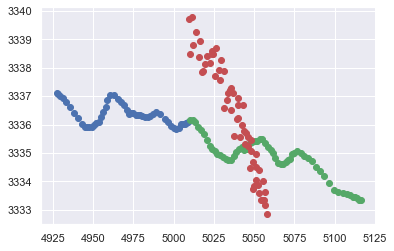

In [66]:
try_num = 2000

total_loss=[]
for i in range(try_num):
    idx=np.random.randint(len(new_total))

    rnn.eval()
    with torch.no_grad():
        k = 50
        s = new_total[idx]
        pred = rnn(s[:,:50,:]).cpu().numpy()
        pred = (np.array(pred).reshape(60,2))*100+offset[idx].numpy()


    ori = (np.array(s.cpu()[:,:50,:]).reshape(50,2))*100+offset[idx].numpy()
    truth = (np.array(s.cpu()[:,50:,:]).reshape(60,2))*100+offset[idx].numpy()
    
    curr_loss = np.mean((pred - truth)**2)
    
    total_loss.append(curr_loss)
    
    if (curr_loss)>400:
        plt.scatter(ori[:,0],ori[:,1],color='b')
        plt.scatter(truth[:,0],truth[:,1],color='g')
        plt.scatter(pred[:,0],pred[:,1],color='r')
        print(curr_loss)
        break


print(np.mean(total_loss))

In [68]:
split = 'test'
cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
#cities = ["palo-alto"] # testing only

total =[]
for city in cities:
    data = get_city_trajectories(city = city, split = split)
    total.extend(torch.tensor(data[0], dtype=torch.float32))

offset = []
new_total = []
for each in total:
    #mean = each[:50].mean(dim=0)
    mean = each[0]
    offset.append(mean)
    new_total.append(((each-mean)/100).reshape(1,50,2).to(torch.device('cuda')))
    


out = []
for idx in range(len(new_total)):
    rnn.eval()
    with torch.no_grad():
        k = 50
        s = new_total[idx]
        pred = rnn(s[:,:50,:]).cpu().numpy()
        pred = (np.array(pred).reshape(60,2))*100+offset[idx].numpy()


    ori = (np.array(s.cpu()[:,:50,:]).reshape(50,2))*100+offset[idx].numpy()
        
    temp = []
    for each in pred:
        temp.append(each[0])
        temp.append(each[1])
    out.append(temp)

    if(idx%((int)(len(new_total)/20))==0):
        print(((int)(idx/len(new_total)*100)),"%")

0 %
0 %
0 %
0 %
0 %
0 %
0 %
0 %
0 %
0 %
0 %
0 %
0 %
0 %
0 %
0 %
0 %
0 %
0 %
0 %
0 %


In [69]:
out_df = pd.DataFrame(out)
sample = pd.read_csv('C:\\Users\\sky\\DESKTOP\\argo2\\sample_submission.csv').set_index('ID')
out_df.columns = sample.columns
out_df.index = sample.index
out_df.to_csv('s2.csv')

out_df.describe()

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
count,29843.000000,29843.000000,29843.000000,29843.000000,29843.000000,29843.000000,29843.000000,29843.000000,29843.000000,29843.000000,...,29843.000000,29843.000000,29843.000000,29843.000000,29843.000000,29843.000000,29843.000000,29843.000000,29843.000000,29843.000000
mean,2830.765869,1075.468628,2830.780029,1075.441162,2830.730225,1075.466553,2830.778564,1075.455688,2830.715576,1075.412231,...,2830.278564,1075.161255,2830.183105,1075.269165,2830.295410,1075.242188,2830.246582,1075.190063,2830.221191,1075.256226
std,3343.226807,1728.491333,3343.222656,1728.458984,3343.217041,1728.460449,3343.190674,1728.446777,3343.197754,1728.438354,...,3342.913086,1728.219849,3342.899902,1728.221313,3342.903076,1728.224365,3342.892334,1728.238647,3342.910889,1728.209229
min,-9198.903320,-4497.569824,-9198.561523,-4497.936523,-9198.703125,-4497.799805,-9198.674805,-4498.099121,-9198.759766,-4497.825684,...,-9197.439453,-4497.865723,-9198.088867,-4497.505859,-9197.914062,-4497.567383,-9198.657227,-4497.810059,-9199.893555,-4497.897461
25%,357.046524,-107.939632,356.492416,-108.177250,355.963257,-107.788399,355.965317,-107.978142,355.489914,-108.555775,...,358.489822,-105.868893,358.407654,-105.717163,357.964355,-105.905670,357.736633,-106.175583,357.734528,-106.168873
50%,2361.646484,1125.448486,2362.197998,1125.404297,2362.192627,1125.372192,2362.179199,1125.331665,2362.319092,1125.426270,...,2360.755615,1126.174438,2360.962158,1126.130127,2361.887451,1125.977539,2361.592041,1125.904663,2361.002197,1125.864868
75%,5416.103516,2324.063232,5416.254150,2324.209351,5416.134277,2324.152832,5416.217773,2324.305176,5416.121338,2324.468140,...,5417.233154,2322.932129,5417.313965,2322.888428,5417.256592,2322.897339,5417.225830,2322.817505,5417.352783,2323.051758
max,13217.038086,6529.260254,13217.369141,6527.320312,13217.523438,6526.735840,13217.666992,6525.446289,13217.993164,6524.673828,...,13233.244141,6484.756348,13232.882812,6483.833984,13233.277344,6483.444824,13233.104492,6483.666504,13233.740234,6482.672852
